In [1]:
%cd code

/opt/ml/project/team/code


In [89]:
import json
import re
from attrdict import AttrDict
from string import Template

from collections import defaultdict
from dataclasses import dataclass
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prepare import get_data
from data_utils import load_dataset, get_examples_from_dialogues, split_slot

plt.rcParams["font.family"] = 'NanumGothicCoding'
plt.style.use('dark_background')

In [3]:
args = AttrDict(
    train_file_name='train_dials.json',
    data_dir= '/opt/ml/input/data/train_dataset',
    ontology_root='/opt/ml/input/data/train_dataset/edit_ontology_metro.json',
    use_convert_ont=False,
    use_domain_slot='basic',
    use_small_data=False,
)

In [4]:
data, slot_meta, ontology = get_data(args)

using train: train_dials.json


In [11]:
examples = get_examples_from_dialogues(
        data, user_first=False, dialogue_level=True, which='all'
)

In [6]:
@dataclass
class TurnFeature:
    guid: str
    current_turn: List[str]
    value: str
    
    def __repr__(self):
        return f'''
{self.guid}
VAL: {self.value}
SYS: {self.current_turn[0]}
USR: {self.current_turn[1]}
'''

In [15]:
slot_dict = defaultdict(list)
for x in slot_meta:
    domain, slot = x.split('-')
    slot_dict[domain].append(x)

In [22]:
slot_dict.keys()

dict_keys(['관광', '숙소', '식당', '지하철', '택시'])

In [127]:
df_dict = {domain:pd.DataFrame(data=0, index=slot_dict[domain], columns=slot_dict[domain]) for domain in slot_dict}
for dialogs in examples:
    for example in dialogs:
        using = defaultdict(list)
        for slot_value in example.label:
            if slot_value in example.before_label:
                continue
            domain, slot, value = split_slot(slot_value, False)
            using[domain].append(f'{domain}-{slot}')
        for key, values in using.items():
            for i in range(len(values)):
#                 df_dict[key].loc[values[i], values[i]] += 1
                for j in range(i+1, len(values)):
                    df_dict[key].loc[values[i], values[j]] += 1
                    df_dict[key].loc[values[j], values[i]] += 1

In [85]:
df_dict.keys()

dict_keys(['관광', '숙소', '식당', '지하철', '택시'])

In [143]:
domain = '지하철'
div = (df_dict[domain].to_numpy().sum() - df_dict[domain].to_numpy().trace()) // 2
a = df_dict[domain] / div

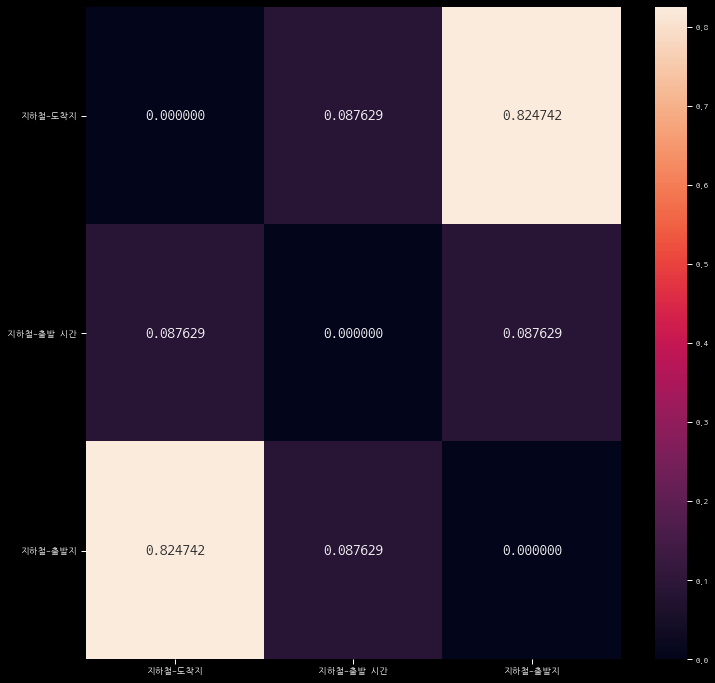

In [144]:
fig = plt.figure(figsize=(12, 12))
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":20,"axes.labelsize":80})
sns.heatmap(a, annot=True, fmt='f')
plt.yticks(rotation=0)
plt.show()

In [124]:
(a <= 0.08)

,택시-도착 시간,택시-도착지,택시-종류,택시-출발 시간,택시-출발지
택시-도착 시간,False,True,True,True,True
택시-도착지,True,False,False,False,False
택시-종류,True,False,False,False,False
택시-출발 시간,True,False,False,False,False
택시-출발지,True,False,False,False,False


In [125]:
pd.where

AttributeError: module 'pandas' has no attribute 'where'